In [1]:
%matplotlib inline

import sys, os

import numpy as np
import matplotlib.pyplot as plt

import toy_osc_analysis_with_ultrasurfaces
from utils.plotting.standard_modules import *

<< PISA_TARGET env var is defined as: "cpu"; PISA is running in double precision (FP64) mode; numba is running on CPU (single core) >>


## Detector response
In this toy analysis, the two mock detector systematics we study are `scale`, $\mu$, and `shape`, $\sigma$, which both affect the reconstructed energy. The `scale` parameter introduces a bias into the reconstruction, while the `shape` parameter changes the resolution. The reconstructed energy follows a log-normal distribution depending on these two parameters, reflecting the fact that the reconstructed energy can never be negative.

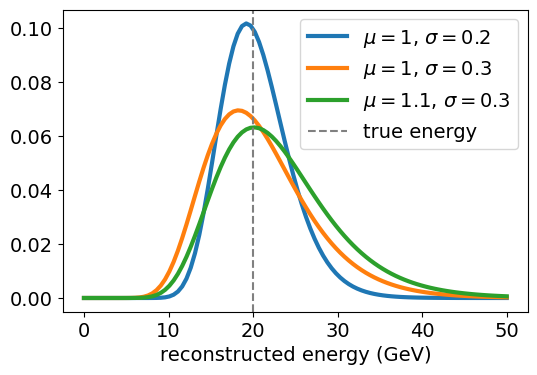

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rc('font', size=14)
from scipy.stats import lognorm

plot_e = np.linspace(0, 50, 100)

true_e = 20
plt.plot(plot_e, lognorm.pdf(plot_e, 0.2, loc=0, scale=true_e), label=r"$\mu = 1$, $\sigma=0.2$")
plt.plot(plot_e, lognorm.pdf(plot_e, 0.3, loc=0, scale=true_e), label=r"$\mu = 1$, $\sigma=0.3$")
# plt.plot(plot_e, lognorm.pdf(plot_e, 0.4, loc=0, scale=true_e), label=r"$\mu = 1$, $\sigma=0.4$")
plt.plot(plot_e, lognorm.pdf(plot_e, 0.3, loc=0, scale=true_e * 1.1), label=r"$\mu = 1.1$, $\sigma=0.3$")
plt.axvline(x=20, color="gray", linestyle="--", lw=1.5, label="true energy")
plt.xlabel("reconstructed energy (GeV)")
plt.legend()
plt.show()

In [3]:
model = toy_osc_analysis_with_ultrasurfaces.ToyOscAnalysisUltrasurf(
    num_mc_events=100000, num_data_events=10000, dropout=True
)
model.reco_energy_bins = np.geomspace(10., 100., 25)

In [4]:
events1 = model.generate_mc_events(scale=1.0, shape=0.3)
template1 = model.get_template()
events2 = model.generate_mc_events(scale=1.1, shape=0.3)
template2 = model.get_template()
events3 = model.generate_mc_events(scale=1.0, shape=0.2)
template3 = model.get_template()
events4 = model.generate_mc_events(scale=1.0, shape=0.4)
template4 = model.get_template()

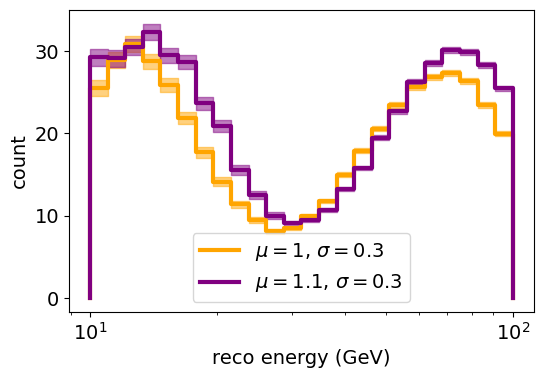

In [5]:
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()
plot_hist(ax=ax, hist=template1, color="orange", label=r"$\mu = 1$, $\sigma=0.3$", errors="band")
plot_hist(ax=ax, hist=template2, color="purple", label=r"$\mu = 1.1$, $\sigma=0.3$", errors="band")
plt.legend()
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")

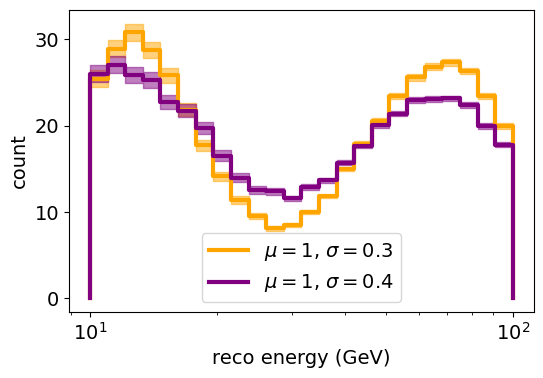

In [6]:
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()
plot_hist(ax=ax, hist=template1, color="orange", label=r"$\mu = 1$, $\sigma=0.3$", errors="band")
plot_hist(ax=ax, hist=template4, color="purple", label=r"$\mu = 1$, $\sigma=0.4$", errors="band")
plt.legend()
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")

## Create systematic sets
We create systematic sets with on-axis and off-axis variations of `scale` and `shape` as we usually would if we were fitting hypersurfaces.

In [7]:
nominal_set = {"scale": 1.0, "shape": 0.3}
sys_sets = [
    # on-axis variations
    {"scale":1.1, "shape":0.3 },
    {"scale":0.9, "shape":0.3 },
    {"scale":1.0, "shape":0.25},
    {"scale":1.0, "shape":0.35},
    # off-axis variations
    {"scale":1.1, "shape":0.25},
    {"scale":1.1, "shape":0.35},
    {"scale":0.9, "shape":0.25},
    {"scale":0.9, "shape":0.35},
]

for dataset in sys_sets + [nominal_set]:
    model = toy_osc_analysis_with_ultrasurfaces.ToyOscAnalysisUltrasurf(
        num_mc_events=100000, num_data_events=100000, dropout=True
    )
    model.reco_energy_bins = np.geomspace(10., 100., 25)
    dataset["events"] = model.generate_mc_events(
        random_state=np.random.RandomState(seed=0), **dataset
    )
    dataset["template"] = model.get_template()
    dataset["model"] = model


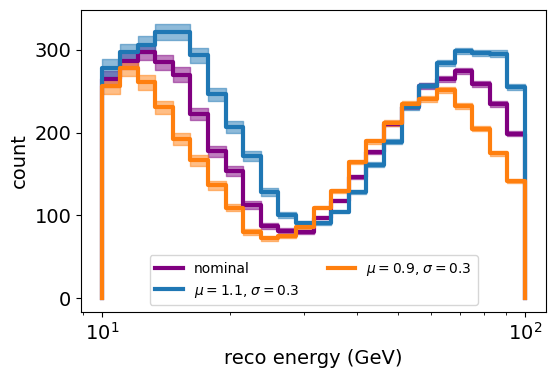

In [8]:
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

plot_hist(ax=ax, hist=nominal_set["template"], label="nominal", color="purple", errors="band")

colors=["tab:blue", "tab:orange", "tab:green", "tab:red"]
for i, dataset in enumerate(sys_sets[:2]):
    plot_hist(
        ax=ax, hist=dataset["model"].get_template(),
        label=fr"$\mu = {dataset['scale']}$, $\sigma={dataset['shape']}$",
        color=colors[i],
        errors="band"
    )
plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")
plt.savefig("systematic_sets_scale.pdf")

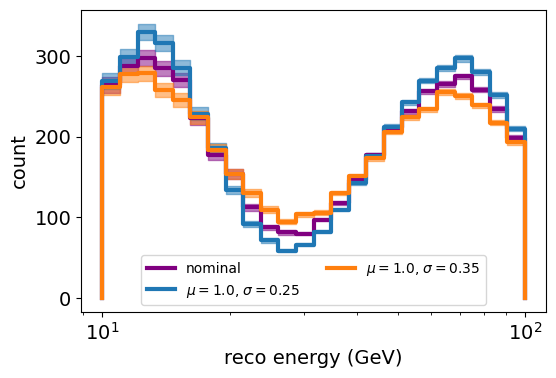

In [9]:
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

plot_hist(ax=ax, hist=nominal_set["template"], label="nominal", color="purple", errors="band")

colors=["tab:blue", "tab:orange", "tab:green", "tab:red"]
for i, dataset in enumerate(sys_sets[2:4]):
    plot_hist(
        ax=ax, hist=dataset["model"].get_template(),
        label=fr"$\mu = {dataset['scale']}$, $\sigma={dataset['shape']}$",
        color=colors[i],
        errors="band"
    )
plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")

## Test re-weighting
The premise of the method is that every event, $i$, in the nominal set with parameters $\mu_{\rm nom}$ and $\sigma_{\rm nom}$ can be re-weighted to model any systematic set, $k$, with parameters $\mu_k$ and $\sigma_k$, based on the _likelihood_ ratio multiplied by the ratio of the total normalization:
$$
R = \frac{P(E_{\mathrm{reco}, i}, E_{\mathrm{true}, i} | \mu_k, \sigma_k)}{P(E_{\mathrm{reco}, i}, E_{\mathrm{true}, i} | \mu_{\rm nom}, \sigma_{\rm nom})}\frac{P(\mu_k, \sigma_k)}{P(\mu_{\rm nom}, \sigma_{\rm nom})}\;.
$$

In this synthetic set, we know exactly what the probabilities are and can re-weight accordingly. The result should be able to reproduce any systematic set within some statistical uncertainty.

In [10]:
# systematic set to be emulated
set_nr = 5
# calculate the denominator of the ratio
prob_nominal = lognorm.pdf(
    nominal_set["model"].events["reco_energy"],
    nominal_set["shape"],
    loc=0,
    scale=nominal_set["model"].events["true_energy"] * nominal_set["scale"]
)
# calculate the nominator
# for consistency, we already establish that set 0 is the nominal set and the systematic
# sets start at index 1
sys_set = sys_sets[set_nr - 1]
prob_sys = lognorm.pdf(
    nominal_set["model"].events["reco_energy"],
    sys_set["shape"],
    loc=0,
    scale=nominal_set["model"].events["true_energy"] * sys_set["scale"]
)
# if we also scale the total number of events, we need to scale by the fraction as well
prob_sys *= sys_set["scale"] / nominal_set["scale"]

# adjust weights (but don't change the initial weights so we don't have to re-create the model)
nominal_set["model"].events["weights"] = nominal_set["model"].events["initial_weights"] * prob_sys / prob_nominal

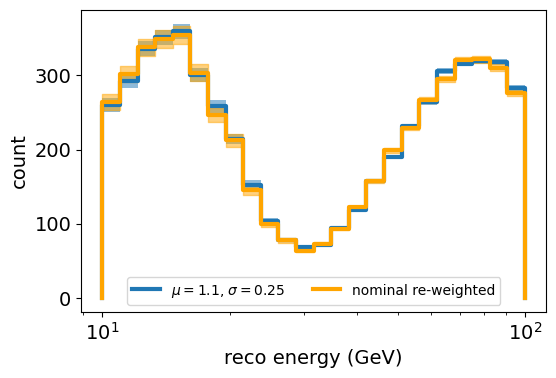

In [11]:
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

plot_hist(
    ax=ax, hist=sys_sets[set_nr - 1]["model"].get_template(),
    label=fr"$\mu = {sys_sets[set_nr - 1]['scale']}$, $\sigma={sys_sets[set_nr - 1]['shape']}$",
    color=None,
    errors="band"
)
plot_hist(ax=ax, hist=nominal_set["model"].get_template(), label="nominal re-weighted", errors="band")

plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")

## Learn re-weighting factor using MLP
In the real world, we don't know $P(E_{\rm true}, E_{\rm reco}|\nu,\mu)$ and we somehow want to learn it with a Machine Learning model. The problem is that $P(E_{\rm true}, E_{\rm reco}|\nu,\mu)$ is a continuous probability distribution, which is difficult to learn in ML (there are ways, but they are quite advanced). But fortunately, we don't have to do that at all! If we instead train a plain old classifier and treat every systematic set, $k$, as a separate class, it is easy to learn the _posterior_ probability (see also __[Neural Network Classifiers Estimate Bayesian a posteriori Probabilities](https://direct.mit.edu/neco/article-abstract/3/4/461/5597/Neural-Network-Classifiers-Estimate-Bayesian-a?redirectedFrom=fulltext)__)
$$
P(\mu_k, \sigma_k | E_{\mathrm{reco}, i}, E_{\mathrm{true}, i})
= P(E_{\mathrm{reco}, i}, E_{\mathrm{true}, i} | \mu_k, \sigma_k)
\frac{P(\mu_k, \sigma_k)}{P(E_{\mathrm{reco}, i}, E_{\mathrm{true}, i})}
\;,
$$
and if we divide these posteriors we find that we get the exact same ratio that we wanted to re-weight events with, 
$$
R=
%\frac{P(E_{\mathrm{reco}, i}, E_{\mathrm{true}, i} | \mu_k, \sigma_k)}{P(E_{\mathrm{reco}, i}, E_{\mathrm{true}, i} | \mu_{\rm nom}, \sigma_{\rm nom})}\frac{P(\mu_k, \sigma_k)}{P(\mu_{\rm nom}, \sigma_{\rm nom})}
%=
\frac{P(\mu_k, \sigma_k | E_{\mathrm{reco}, i}, E_{\mathrm{true}, i})}{P(\mu_{\rm nom}, \sigma_{\rm nom} | E_{\mathrm{reco}, i}, E_{\mathrm{true}, i} )}\;,
$$
where the term $P(E_{\mathrm{reco}, i}, E_{\mathrm{true}, i})$ exactly cancels.
Therefore, all we need to do is to train a classifier to distinguish between systematic sets (including the nominal set). It is important that we _don't_ balance the classes in this classification, because we want to include the class normalizations!

### Build the dataset
The features for each sample are (true_energy, reco_energy) and the class labels are the set numbers, where set number 0 is the nominal set.

In [12]:
X_nom = np.vstack((nominal_set["model"].events["true_energy"], nominal_set["model"].events["reco_energy"])).T

X_sys = [
    np.vstack((sys_set["model"].events["true_energy"], sys_set
               ["model"].events["reco_energy"])).T
    for sys_set in sys_sets
]

X = np.vstack([X_nom] + X_sys)
y = np.hstack(
    [np.full(len(dataset["model"].events["true_energy"]), i)
     for i, dataset in enumerate([nominal_set] + sys_sets)]
)

print(X[:10])
print(y[:10])

# shuffle
random_idx = np.random.permutation(len(X))
X = X[random_idx]
y = y[random_idx]

print(X[:10])
print(y[:10])

[[ 54.92646904  72.20044542]
 [ 71.5474177   73.27517335]
 [ 60.31606127  45.36800159]
 [ 54.53382998  54.62716399]
 [ 42.42311445  73.49702254]
 [ 64.6248219   69.43272136]
 [ 43.81496241  40.05072364]
 [ 89.18812278  85.91710635]
 [ 96.36990977 105.46586893]
 [ 38.40580773  34.01244356]]
[0 0 0 0 0 0 0 0 0 0]
[[60.65587423 37.07310536]
 [24.80224553 21.98174295]
 [85.62435878 33.90382949]
 [62.99886844 60.89247684]
 [41.29274818 15.89217094]
 [38.71139312 38.54802945]
 [10.48414175  8.28768373]
 [17.43487003 20.9463197 ]
 [73.98586031 85.27049861]
 [51.49983182 51.84434971]]
[1 7 2 0 4 6 1 5 7 5]


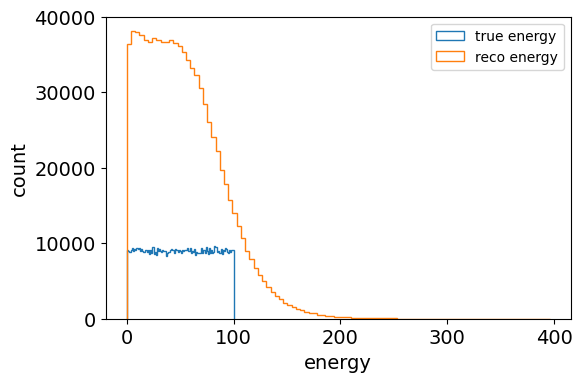

In [13]:
# The dataset should now contain the true and reco energies of all sets combined
plt.hist(X[:, 0], histtype="step", bins=100, label="true energy")
plt.hist(X[:, 1], histtype="step", bins=100, label="reco energy")
plt.xlabel("energy")
plt.ylabel("count")
plt.legend(fontsize=10)
plt.show()

### Build and train the classifier

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

# a transformer to make all of the input data normal... classifiers like this
trafo = preprocessing.PowerTransformer(method='box-cox', standardize=True)
# trafo = preprocessing.StandardScaler()

In [15]:
X_transformed = trafo.fit_transform(X)

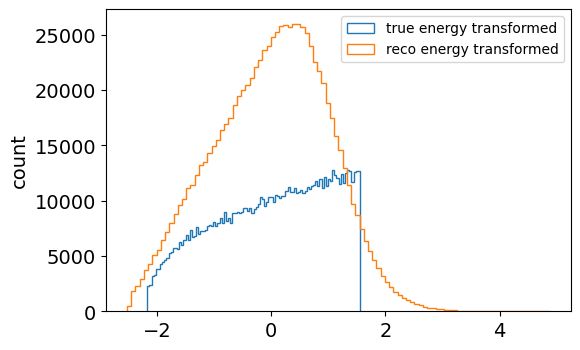

In [16]:
plt.hist(X_transformed[:, 0], histtype="step", bins=100, label="true energy transformed")
plt.hist(X_transformed[:, 1], histtype="step", bins=100, label="reco energy transformed")
plt.ylabel("count")
plt.legend(fontsize=10)
plt.show()

### Optionally: Find the best ML parameters using grid-search with cross-validation
This takes some time, but we could use this to find better hyper-parameters. However, the way it is implemented below is not optimal for our purposes: We don't actually care about the score, we care about how well the network ends up being able to imitate any other systematic set starting from the nominal set. We could define a different cross-validation score instead that checks the likelihood difference between histograms that are created this way.

In [194]:
# finding better hyper-parameters using grid search
from pprint import pprint
from time import time
import logging
from sklearn.model_selection import GridSearchCV

parameters = {
    "mlp__alpha": [1e-2, 1e-3, 1e-4],
    "mlp__hidden_layer_sizes": [(10, 5), (20, 10, 5), (40, 20, 10, 5)]
}

pipe = Pipeline(
    [("transform", trafo), ("mlp", mlp)]
)
grid_search = GridSearchCV(pipe, parameters, n_jobs=16, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipe.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X, y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# GridSearchCV automatically re-fits the best estimator on the entire set
pipe = grid_search.best_estimator_

Performing grid search...
pipeline: ['transform', 'mlp']
parameters:
{'mlp__alpha': [0.01, 0.001, 0.0001, 1e-05],
 'mlp__hidden_layer_sizes': [(20, 10), (10, 5), (20, 10, 5), (30, 20, 10, 5)]}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
done in 599.860s

Best score: 0.165
Best parameters set:
	mlp__alpha: 0.01
	mlp__hidden_layer_sizes: (10, 5)


### Just use good pre-defined parameters
The parameters below turned out to work pretty well regardless of what the cross-validation found.

In [17]:
mlp = MLPClassifier(
    solver='adam',
    alpha=1e-3,
    # tanh activation function helps to prevent extreme values and makes the
    # output smoother than ReLU
    activation="tanh",
    hidden_layer_sizes=(20, 10, 5),
    random_state=1
)
pipe = Pipeline(
    [("transform", trafo), ("mlp", mlp)]
)
pipe.fit(X, y)

Pipeline(steps=[('transform', PowerTransformer(method='box-cox')),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.001,
                               hidden_layer_sizes=(20, 10, 5),
                               random_state=1))])

## Plotting the prediction
The first thing we need to establish is that the probability ratio can actually be reproduced. We choose a given true energy and scan over the reco energy and plot the output from the network.

In [18]:
true_e = 30
reco_e = np.linspace(10, 100, 100)
x_pred = np.zeros((100, 2))
x_pred[:, 0] = true_e
x_pred[:, 1] = reco_e

# class predictions aren't super meaningful yet, but a good first step
pipe.predict(x_pred)

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 2, 7, 7, 7, 7, 7, 7, 3, 3, 3,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

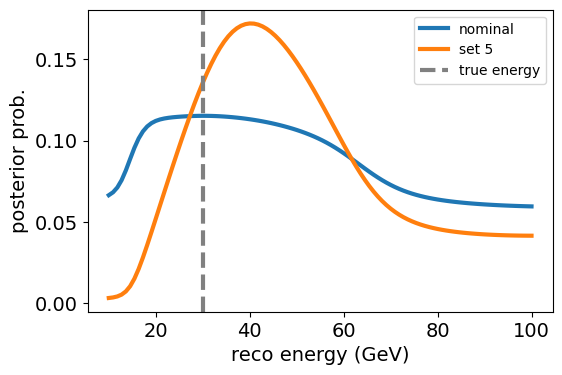

In [19]:
# These are the predicted *posterior* probabilities
set_nr = 5
posterior_nom = pipe.predict_proba(x_pred)[:, 0]
posterior_sys = pipe.predict_proba(x_pred)[:, set_nr]

plt.plot(reco_e, posterior_nom, label="nominal")
plt.plot(reco_e, posterior_sys, label=f"set {set_nr}")
plt.axvline(x=30, label="true energy", color="gray", linestyle="--")
plt.xlabel("reco energy (GeV)")
plt.ylabel("posterior prob.")
plt.legend(fontsize=10)

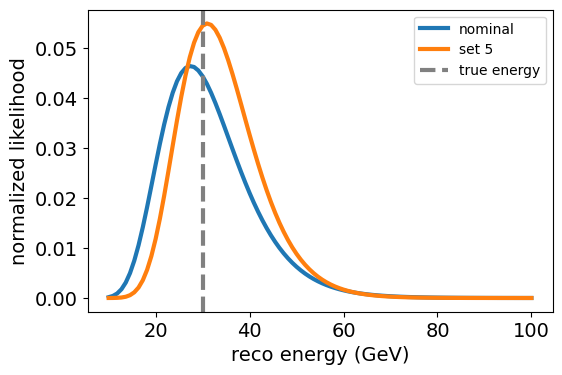

In [20]:
prob_nom = lognorm.pdf(reco_e, nominal_set["shape"], loc=0, scale=true_e * nominal_set["scale"])
prob_sys = lognorm.pdf(reco_e, sys_sets[set_nr-1]["shape"], loc=0, scale=true_e * sys_sets[set_nr-1]["scale"])

prob_sys *= sys_sets[set_nr-1]["scale"] / nominal_set["scale"]

plt.plot(
    reco_e,
    prob_nom,
    label="nominal"
)
plt.plot(
    reco_e,
    prob_sys,
    label=f"set {set_nr}"
)
plt.axvline(x=30, label="true energy", color="gray", linestyle="--")
plt.xlabel("reco energy (GeV)")
plt.ylabel("normalized likelihood")
plt.legend(fontsize=10)

### Plot the re-weighting ratio
We claimed that the ratio of likelihoods shoul be equal to the ratio of posteriors. We find that that is indeed the case, up to some threshold in energy. If we look at the distributions above, we see that events at these energies or above are exceedingly unlikely, so that the network doesn't see enough examples to estimate the likelihood fraction accurately. That shouldn't be too much of a problem since those events are, by construction, very rare.

Text(0, 0.5, 're-weight ratio')

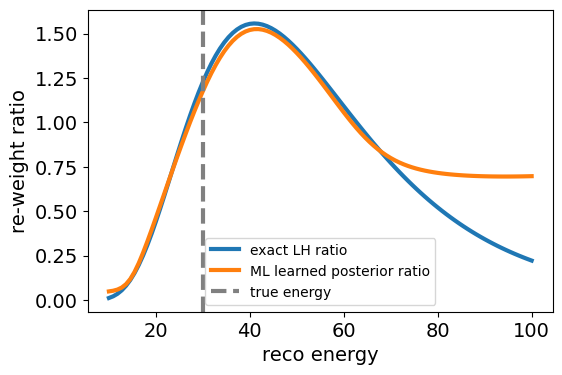

In [21]:
plt.plot(reco_e, prob_sys / prob_nom, label="exact LH ratio")
plt.plot(reco_e, posterior_sys / posterior_nom, label="ML learned posterior ratio")
plt.axvline(x=30, label="true energy", color="gray", linestyle="--")
# plt.axhline(y=sys_sets[set_nr-1]["scale"] / nominal_set["scale"], label="class prior", color="gray", linestyle=":")
plt.legend(fontsize=10)
plt.xlabel("reco energy")
plt.ylabel("re-weight ratio")

## Emulating any systematic set using the ML learned weights
To put is all together, we should now be able to emulate any systematic set by re-weighting according to the posterior ratio predicted by our model.

In [22]:
nominal_set_probabilities = pipe.predict_proba(X_nom)
# systematic set to be emulated
set_nr = 5
# calculate the denominator of the ratio
posterior_nominal = nominal_set_probabilities[:, 0]
# calculate the nominator
posterior_sys = nominal_set_probabilities[:, set_nr]
# adjust weights (but don't change the initial weights so we don't have to re-create the model)
nominal_set["model"].events["weights"] = (
    nominal_set["model"].events["initial_weights"] * posterior_sys / posterior_nominal
)

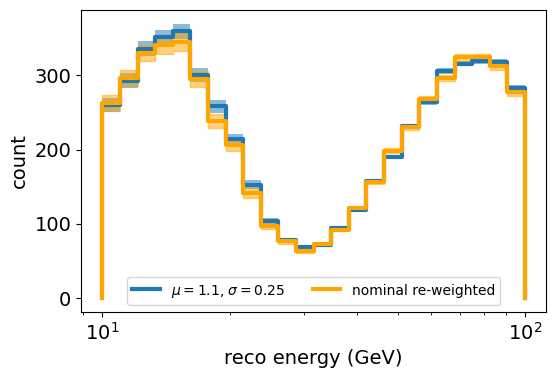

In [23]:
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

plot_hist(
    ax=ax, hist=sys_sets[set_nr - 1]["model"].get_template(),
    label=fr"$\mu = {sys_sets[set_nr - 1]['scale']}$, $\sigma={sys_sets[set_nr - 1]['shape']}$",
    color=None,
    errors="band"
)
plot_hist(ax=ax, hist=nominal_set["model"].get_template(), label="nominal re-weighted", errors="band")

plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")

## Calculating "ultrasurfaces" 
The final step is to convert the outputs of the network into gradients for every single event. As long as the changes in weights are approximately linear as a function of $\sigma$ and $\mu$, we should be able to accurately re-weight events with just two gradients for each parameter. If higher-order effects play a role, we can also choose to generate polynomial features and fitting gradients to those features.

### Example: Linear regression on one event

In [24]:
# create an example event at some true and reco energy and plot the output probabilities for that event
true_e = 30
reco_e = 40

sigma_nom = nominal_set["shape"]
mu_nom = nominal_set["scale"]

pred_probs = pipe.predict_proba(np.atleast_2d([true_e, reco_e]))[0]
# divide out the nominal prob to get the re-scale ratio
pred_probs = pred_probs / pred_probs[0]

sigmas = np.array([dataset["shape"] for dataset in [nominal_set] + sys_sets]) - sigma_nom
mus = np.array([dataset["scale"] for dataset in [nominal_set] + sys_sets]) - mu_nom

In [25]:
# using the theil sen regressor so that the result is robust w.r.t. outliers
from sklearn.linear_model import TheilSenRegressor

event_x = np.vstack((mus, sigmas)).T
# because we fit without intercept, we must subtract the offset of 1!
event_y = pred_probs - 1

reg = TheilSenRegressor(random_state=0, fit_intercept=False).fit(event_x, event_y)

In [26]:
# these are the slopes we are after!
reg.coef_

array([3.75381318e+00, 1.09799531e-03])

In [27]:
np.dot(np.atleast_2d([0.04, 0.05]), reg.coef_)

array([0.15020743])

In [28]:
reg.predict(np.atleast_2d([0.04, 0.05]))

array([0.15020743])

Text(0.5, 0, 'R')

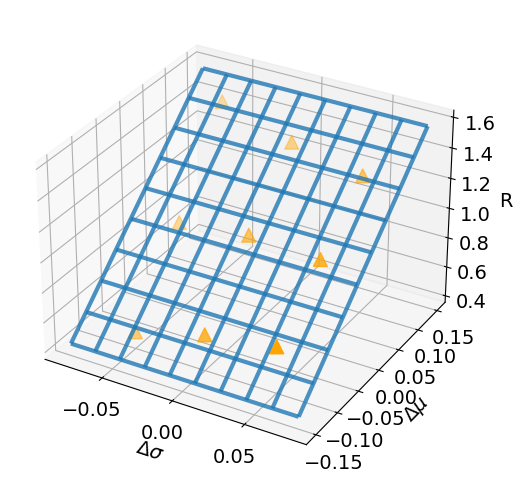

In [29]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rc('font', size=14)

fig = plt.figure(figsize=(6, 7))

plot_sig = np.linspace(-0.08, 0.08, 10)
plot_mu = np.linspace(-0.15, 0.15, 10)
plot_mesh_sig, plot_mesh_mu = np.meshgrid(plot_sig, plot_mu)

# the prediction has no intercept, but per construction the offset should be 1
plot_mesh_pred = reg.predict(
    np.vstack((plot_mesh_mu.ravel(), plot_mesh_sig.ravel())).T
).reshape(plot_mesh_sig.shape) + 1

ax = fig.add_subplot(projection='3d')

ax.plot_wireframe(plot_mesh_sig, plot_mesh_mu, plot_mesh_pred, alpha=0.8)

ax.scatter(sigmas, mus, pred_probs, marker="^", s=100, color="orange")
ax.set_xlabel(r"$\Delta\sigma$")
ax.set_ylabel(r"$\Delta\mu$")
ax.set_zlabel("R")
# plt.savefig("single_event_ultrasurface.pdf")

### Modeling second-order effects

We can see in the figure that there definitely should be a non-linear component here... If need be, we can also create polynomial features of second order and compute gradients w.r.t. those features to capture second order effects. Such a transformation replaces the features $(x_1, x_2)$ with $(x_1, x_2, x_1^2, x_1 x_2, x_2^2)$, where we neglect bias because it should be zero by construction. We can also neglect the squared terms and include only interaction terms if that turns out to be sufficient so that we may save even more space.

In [30]:
event_x = np.vstack((mus, sigmas)).T

from sklearn.preprocessing import PolynomialFeatures

print("input:")
print(event_x)
poly = PolynomialFeatures(2, include_bias=False, interaction_only=False)
print("polynomial features:")
print(poly.fit_transform(event_x))

# because we fit without intercept, we must subtract the offset of 1!
#event_y = pred_probs - 1

reg = TheilSenRegressor(random_state=0, fit_intercept=False)
event_pipe = Pipeline((("poly_features", poly), ("regression", reg)))
event_pipe.fit(event_x, event_y)
print("gradients w.r.t. polynomial features:")
print(event_pipe[1].coef_)

input:
[[ 0.    0.  ]
 [ 0.1   0.  ]
 [-0.1   0.  ]
 [ 0.   -0.05]
 [ 0.    0.05]
 [ 0.1  -0.05]
 [ 0.1   0.05]
 [-0.1  -0.05]
 [-0.1   0.05]]
polynomial features:
[[ 0.      0.      0.      0.      0.    ]
 [ 0.1     0.      0.01    0.      0.    ]
 [-0.1     0.      0.01   -0.      0.    ]
 [ 0.     -0.05    0.     -0.      0.0025]
 [ 0.      0.05    0.      0.      0.0025]
 [ 0.1    -0.05    0.01   -0.005   0.0025]
 [ 0.1     0.05    0.01    0.005   0.0025]
 [-0.1    -0.05    0.01    0.005   0.0025]
 [-0.1     0.05    0.01   -0.005   0.0025]]
gradients w.r.t. polynomial features:
[  3.99952436   0.15045208  -0.50849417 -17.69079272  -9.35862288]


Text(0.5, 0, 'R')

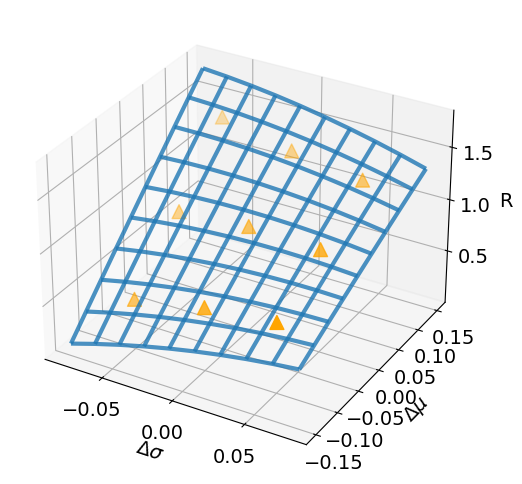

In [31]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rc('font', size=14)

fig = plt.figure(figsize=(6, 7))

plot_sig = np.linspace(-0.08, 0.08, 10)
plot_mu = np.linspace(-0.15, 0.15, 10)
plot_mesh_sig, plot_mesh_mu = np.meshgrid(plot_sig, plot_mu)

# the prediction has no intercept, but per construction the offset should be 1
plot_mesh_pred = event_pipe.predict(
    np.vstack((plot_mesh_mu.ravel(), plot_mesh_sig.ravel())).T
).reshape(plot_mesh_sig.shape) + 1

ax = fig.add_subplot(projection='3d')

ax.plot_wireframe(plot_mesh_sig, plot_mesh_mu, plot_mesh_pred, alpha=0.8)

ax.scatter(sigmas, mus, pred_probs, marker="^", s=100, color="orange")
ax.set_xlabel(r"$\Delta\sigma$")
ax.set_ylabel(r"$\Delta\mu$")
ax.set_zlabel("R")

It seems that second order effects really are important to interpolate the class predictions accurately.

### Calculating gradients for all events

In [32]:
nom_events = nominal_set["model"].events

sigma_nom = nominal_set["shape"]
mu_nom = nominal_set["scale"]

# the sigmas and mus for the systematic sets stay the same
sigmas = np.array([dataset["shape"] for dataset in [nominal_set] + sys_sets]) - sigma_nom
mus = np.array([dataset["scale"] for dataset in [nominal_set] + sys_sets]) - mu_nom

poly = PolynomialFeatures(2, include_bias=False, interaction_only=False)
event_x = poly.fit_transform(np.vstack((mus, sigmas)).T)

n_events = len(nom_events["weights"])
nom_events["gradients"] = np.zeros((n_events, event_x.shape[1]))

# looping over many events in Python is super slow... but unfortunately there is no
# version of the TheilSenRegressor that will make many different regressions at once
for i, (true_e, reco_e) in enumerate(zip(nom_events["true_energy"], nom_events["reco_energy"])):
    pred_probs = pipe.predict_proba(np.atleast_2d([true_e, reco_e]))[0]
    # divide out the nominal prob to get the re-scale ratio
    pred_probs = pred_probs / pred_probs[0]
    
    # because we fit without intercept, we must subtract the offset of 1!
    event_y = pred_probs - 1
    reg = TheilSenRegressor(random_state=0, fit_intercept=False).fit(event_x, event_y)
    
    # extract the gradients from the estimator
    nom_events["gradients"][i] = reg.coef_

In [33]:
nominal_set["model"].events["gradients"]

array([[  4.03732181,   0.11089402,  -0.26918425, -17.70467072,
         -9.15501118],
       [  1.43071468,  -2.75198786,  -5.87184026,  -8.99324187,
          4.2065982 ],
       [ -2.20965932,  -0.19200933,  -2.46135723,  16.68901095,
         -4.19313746],
       ...,
       [  1.20497107,  -2.78692717,  -6.0408475 ,  -7.11475407,
          4.4111756 ],
       [  3.20737237,  -1.3524724 ,  -2.44330329, -19.13542812,
         -3.39980517],
       [  4.13550422,   0.40781735,  -0.12758948, -17.35186118,
         -9.60403201]])

## Emulate any systematic set using event gradients
This is the final demonstration of the method: Can we reproduce any systematic sets given the gradients we have computed?
We find that the Theil-Sen estimated gradients seem to introduce some amount of bias, but not too badly. Perhaps the linearity of the re-weighting factor is somewhat violated since the changes to the distributions are substantial. Nevertheless, the results below are encouraging!

In [34]:
# systematic set to be emulated
set_nr = 4

set_mu = sys_sets[set_nr - 1]["scale"]
set_sig = sys_sets[set_nr - 1]["shape"]

sigma_nom = nominal_set["shape"]
mu_nom = nominal_set["scale"]

delta_mu = set_mu - mu_nom
delta_sig = set_sig - sigma_nom

features = poly.fit_transform(np.atleast_2d([delta_mu, delta_sig]))[0]

# mu_grad = nominal_set["model"].events["grad_scale"]
# sig_grad = nominal_set["model"].events["grad_shape"]

gradients = nominal_set["model"].events["gradients"]

weight_factor = 1. + np.dot(gradients, features)

# adjust weights (but don't change the initial weights so we don't have to re-create the model)
nominal_set["model"].events["weights"] = (
    nominal_set["model"].events["initial_weights"] * weight_factor
)

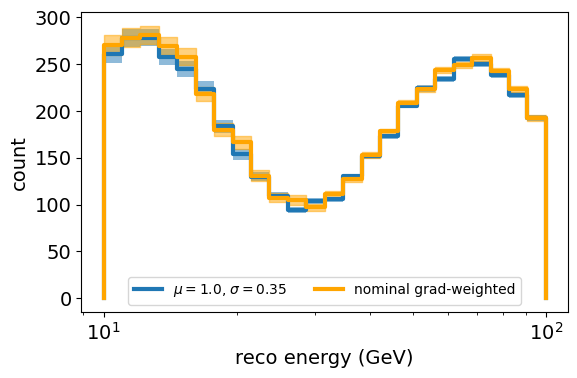

In [35]:
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

plot_hist(
    ax=ax, hist=sys_sets[set_nr - 1]["model"].get_template(),
    label=fr"$\mu = {sys_sets[set_nr - 1]['scale']}$, $\sigma={sys_sets[set_nr - 1]['shape']}$",
    color=None,
    errors="band"
)

# adjust weights (but don't change the initial weights so we don't have to re-create the model)
nominal_set["model"].events["weights"] = (
    nominal_set["model"].events["initial_weights"] * weight_factor
)

plot_hist(
    ax=ax,
    hist=nominal_set["model"].get_template(),
    label="nominal grad-weighted",
    errors="band",
    # color=None
)



plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")
plt.tight_layout()
# plt.savefig("grad_weighted_sys_set_mu_1.1_sig_0.3.pdf")

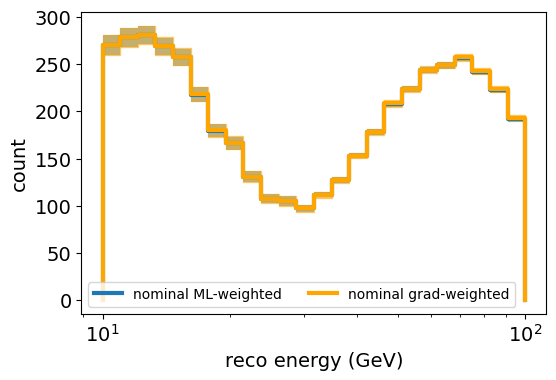

In [36]:
# compare with direct ML re-weighting
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

# calculate the denominator of the ratio
posterior_nominal = nominal_set_probabilities[:, 0]
# calculate the nominator
posterior_sys = nominal_set_probabilities[:, set_nr]
# adjust weights (but don't change the initial weights so we don't have to re-create the model)
nominal_set["model"].events["weights"] = (
    nominal_set["model"].events["initial_weights"] * posterior_sys / posterior_nominal
)
plot_hist(
    ax=ax,
    hist=nominal_set["model"].get_template(),
    label="nominal ML-weighted",
    errors="band",
    color=None
)

# adjust weights (but don't change the initial weights so we don't have to re-create the model)
nominal_set["model"].events["weights"] = (
    nominal_set["model"].events["initial_weights"] * weight_factor
)
plot_hist(
    ax=ax,
    hist=nominal_set["model"].get_template(),
    label="nominal grad-weighted",
    errors="band",
    # color=None
)


plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")

## Test integrated fit method
Here we test the ultrasurface fit method that is implemented in the toy analysis and which summarizes everything we did here.

In [37]:
from importlib import reload
reload(toy_osc_analysis_with_ultrasurfaces)

model = toy_osc_analysis_with_ultrasurfaces.ToyOscAnalysisUltrasurf(
    num_mc_events=100000, num_data_events=10000, dropout=True
)
model.reco_energy_bins = np.geomspace(10., 100., 25)

In [38]:
model.fit_ultrasurface(poly_degree=2)

generating MC...
assembling dataset...
fitting classifier...
fitting gradients to classifier predictions...
Ultrasurface fit finished!


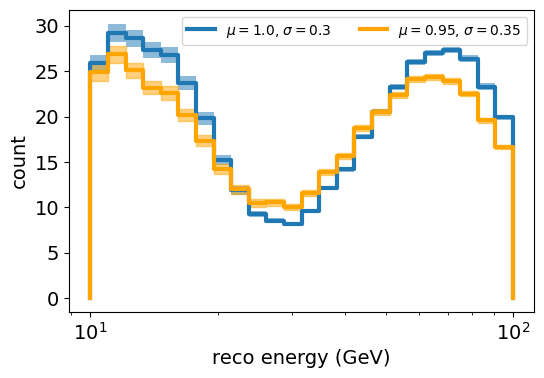

In [39]:
model.params["scale"].value = 1.0
model.params["shape"].value = 0.3

fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

plot_hist(
    ax=ax,
    hist=model.get_template(),
    label=fr"$\mu = {model.params['scale'].value}$, $\sigma={model.params['shape'].value}$",
    color=None,
    errors="band"
)

model.params["scale"].value = 0.95
model.params["shape"].value = 0.35

plot_hist(
    ax=ax,
    hist=model.get_template(),
    label=fr"$\mu = {model.params['scale'].value}$, $\sigma={model.params['shape'].value}$",
    color="orange",
    errors="band"
)

plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")

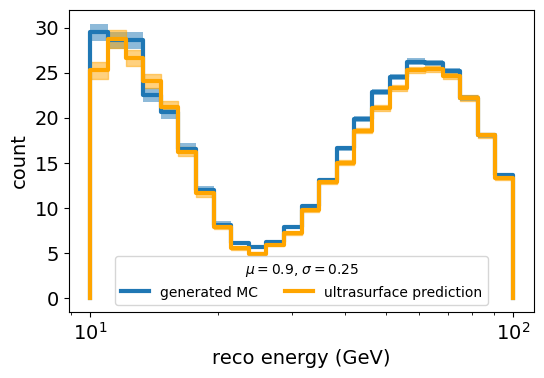

In [40]:
sys_scale = 0.9
sys_shape = 0.25

sys_model = toy_osc_analysis_with_ultrasurfaces.ToyOscAnalysisUltrasurf(
    num_mc_events=100000, num_data_events=10000, dropout=True
)
sys_model.reco_energy_bins = np.geomspace(10., 100., 25)

sys_model.generate_mc_events(scale=sys_scale, shape=sys_shape)

fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

plot_hist(
    ax=ax,
    hist=sys_model.get_template(),
    label="generated MC",
    color=None,
    errors="band"
)

model.params["scale"].value = sys_scale
model.params["shape"].value = sys_shape

plot_hist(
    ax=ax,
    hist=model.get_template(),
    label="ultrasurface prediction",
    errors="band",
    # color=None
)


plt.legend(
    title=fr"$\mu = {sys_scale}$, $\sigma={sys_shape}$",
    ncol=2, fontsize=10, title_fontsize=10,
    loc="lower center"
)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")